# Import

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import copy

import pickle
from datetime import datetime

import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import poisson
from scipy import spatial

# import code
from simulation import Simulation
from replicate_graph import layer_graph
import data
from data import select_dataset, get_station_g, set_random_speed_columns
from visualization import set_draw_attributes

import os

import re
from tqdm import tqdm

# Simulation

Intialize the simulation with basic parameters.

In [45]:
dataset = "wcctci"
simulation_length = 24
battery_interval = 20
km_per_percent = 6
sim = Simulation("wcctci", simulation_length, battery_interval, km_per_percent)

KeyboardInterrupt: 

Add source and destination nodes, with custom or random distributions.

In [4]:
# Run this cell for custom distributions

# src_dstr = [10,20,30,40,50,60,50,40,30,20,30,40,50,60,50,40,30,20,10,5,0,0,0,0]
# sim.add_src("0",src_dstr)

# sim.add_dst("0",5)

In [5]:
# Run this cell for random (you can set average source volumes and stdevs, else default)

sim.random_srcs()
sim.random_dsts()

In [6]:
sim.run()

100%|██████████| 24/24 [07:16<00:00, 18.20s/it]


In [8]:
for v in sim.vehicle_list:
    print(v.path)

['5', '5_100_in', '5_100_out', '14_20_in', '14_20_out', '14']
['5', '5_100_in', '5_100_out', '4_0_in', '4_0_out', '4']
['7', '7_100_in', '7_100_out', '41_0_in', '41_0_out', '41']
['7', '7_100_in', '7_100_out', '16_0_in', '16_100_out', '21_0_in', '21_0_out', '21']
['8', '8_100_in', '8_100_out', '9_20_in', '9_20_out', '9']
['8', '8_100_in', '8_100_out', '36_0_in', '36_0_out', '36']
['8', '8_100_in', '8_100_out', '34_0_in', '34_0_out', '34']
['14', '14_100_in', '14_100_out', '36_0_in', '36_0_out', '36']
['14', '14_100_in', '14_100_out', '18_0_in', '18_0_out', '18']
['17', '17_100_in', '17_100_out', '22_0_in', '22_0_out', '22']
['17', '17_100_in', '17_100_out', '5_0_in', '5_0_out', '5']
['17', '17_100_in', '17_100_out', '40_0_in', '40_0_out', '40']
['20', '20_100_in', '20_100_out', '23_0_in', '23_0_out', '23']
['21', '21_100_in', '21_100_out', '28_40_in', '28_40_out', '28']
['21', '21_100_in', '21_100_out', '42_0_in', '42_0_out', '42']
['21', '21_100_in', '21_100_out', '34_0_in', '34_0_out

['20', '20_100_in', '20_100_out', '22_0_in', '22_0_out', '22']
['20', '20_100_in', '20_100_out', '2_0_in', '2_0_out', '2']
['20', '20_100_in', '20_100_out', '23_0_in', '23_0_out', '23']
['21', '21_100_in', '21_100_out', '39_0_in', '39_0_out', '39']
['21', '21_100_in', '21_100_out', '30_40_in', '30_40_out', '30']
['21', '21_100_in', '21_100_out', '12_0_in', '12_0_out', '12']
['21', '21_100_in', '21_100_out', '2_0_in', '2_0_out', '2']
['21', '21_100_in', '21_100_out', '8_0_in', '8_0_out', '8']
['21', '21_100_in', '21_100_out', '10_20_in', '10_20_out', '10']
['22', '22_100_in', '22_100_out', '9_0_in', '9_0_out', '9']
['22', '22_100_in', '22_100_out', '19_0_in', '19_0_out', '19']
['24', '24_100_in', '24_100_out', '18_0_in', '18_0_out', '18']
['24', '24_100_in', '24_100_out', '10_0_in', '10_100_out', '7_0_in', '7_0_out', '7']
['24', '24_100_in', '24_100_out', '2_0_in', '2_0_out', '2']
['24', '24_100_in', '24_100_out', '13_0_in', '13_0_out', '13']
['24', '24_100_in', '24_100_out', '22_20_in'

['24', '24_100_in', '24_100_out', '35_0_in', '35_0_out', '35']
['24', '24_100_in', '24_100_out', '23_0_in', '23_0_out', '23']
['24', '24_100_in', '24_100_out', '28_0_in', '28_0_out', '28']
['24', '24_100_in', '24_100_out', '22_20_in', '22_100_out', '38_0_in', '38_0_out', '38']
['24', '24_100_in', '24_100_out', '5_0_in', '5_0_out', '5']
['24', '24_100_in', '24_100_out', '33_0_in', '33_0_out', '33']
['24', '24_100_in', '24_100_out', '2_0_in', '2_0_out', '2']
['24', '24_100_in', '24_100_out', '13_0_in', '13_0_out', '13']
['25', '25_100_in', '25_100_out', '28_0_in', '28_0_out', '28']
['25', '25_100_in', '25_100_out', '2_0_in', '2_0_out', '2']
['25', '25_100_in', '25_100_out', '32_0_in', '32_0_out', '32']
['25', '25_100_in', '25_100_out', '41_0_in', '41_0_out', '41']
['25', '25_100_in', '25_100_out', '35_0_in', '35_0_out', '35']
['25', '25_100_in', '25_100_out', '27_0_in', '27_100_out', '15_0_in', '15_0_out', '15']
['25', '25_100_in', '25_100_out', '18_0_in', '18_0_out', '18']
['25', '25_10

['22', '22_100_in', '22_100_out', '19_0_in', '19_0_out', '19']
['22', '22_100_in', '22_100_out', '21_0_in', '21_0_out', '21']
['24', '24_100_in', '24_100_out', '29_0_in', '29_100_out', '16_0_in', '16_0_out', '16']
['24', '24_100_in', '24_100_out', '27_0_in', '27_0_out', '27']
['24', '24_100_in', '24_100_out', '25_0_in', '25_0_out', '25']
['24', '24_100_in', '24_100_out', '18_0_in', '18_0_out', '18']
['24', '24_100_in', '24_100_out', '30_0_in', '30_0_out', '30']
['24', '24_100_in', '24_100_out', '33_0_in', '33_0_out', '33']
['24', '24_100_in', '24_100_out', '4_0_in', '4_0_out', '4']
['24', '24_100_in', '24_100_out', '33_0_in', '33_0_out', '33']
['24', '24_100_in', '24_100_out', '20_0_in', '20_0_out', '20']
['24', '24_100_in', '24_100_out', '37_0_in', '37_0_out', '37']
['25', '25_100_in', '25_100_out', '27_0_in', '27_0_out', '27']
['25', '25_100_in', '25_100_out', '12_0_in', '12_0_out', '12']
['25', '25_100_in', '25_100_out', '31_0_in', '31_0_out', '31']
['25', '25_100_in', '25_100_out',

['21', '21_100_in', '21_100_out', '26_80_in', '26_80_out', '26']
['21', '21_100_in', '21_100_out', '11_0_in', '11_0_out', '11']
['21', '21_100_in', '21_100_out', '32_0_in', '32_0_out', '32']
['21', '21_100_in', '21_100_out', '13_0_in', '13_0_out', '13']
['21', '21_100_in', '21_100_out', '25_0_in', '25_0_out', '25']
['21', '21_100_in', '21_100_out', '4_0_in', '4_0_out', '4']
['21', '21_100_in', '21_100_out', '33_0_in', '33_0_out', '33']
['21', '21_100_in', '21_100_out', '29_80_in', '29_80_out', '29']
['21', '21_100_in', '21_100_out', '2_0_in', '2_0_out', '2']
['21', '21_100_in', '21_100_out', '41_0_in', '41_0_out', '41']
['21', '21_100_in', '21_100_out', '13_0_in', '13_0_out', '13']
['21', '21_100_in', '21_100_out', '39_0_in', '39_0_out', '39']
['21', '21_100_in', '21_100_out', '19_0_in', '19_0_out', '19']
['22', '22_100_in', '22_100_out', '42_0_in', '42_0_out', '42']
['22', '22_100_in', '22_100_out', '19_0_in', '19_0_out', '19']
['22', '22_100_in', '22_100_out', '24_0_in', '24_0_out', 

['8', '8_100_in', '8_100_out', '13_0_in', '13_0_out', '13']
['8', '8_100_in', '8_100_out', '21_0_in', '21_0_out', '21']
['8', '8_100_in', '8_100_out', '24_0_in', '24_0_out', '24']
['8', '8_100_in', '8_100_out', '29_0_in', '29_0_out', '29']
['8', '8_100_in', '8_100_out', '18_0_in', '18_0_out', '18']
['8', '8_100_in', '8_100_out', '18_0_in', '18_0_out', '18']
['8', '8_100_in', '8_100_out', '14_0_in', '14_0_out', '14']
['8', '8_100_in', '8_100_out', '2_0_in', '2_0_out', '2']
['8', '8_100_in', '8_100_out', '27_0_in', '27_0_out', '27']
['8', '8_100_in', '8_100_out', '35_0_in', '35_0_out', '35']
['8', '8_100_in', '8_100_out', '42_0_in', '42_0_out', '42']
['8', '8_100_in', '8_100_out', '21_0_in', '21_0_out', '21']
['8', '8_100_in', '8_100_out', '10_0_in', '10_0_out', '10']
['8', '8_100_in', '8_100_out', '37_0_in', '37_0_out', '37']
['8', '8_100_in', '8_100_out', '22_0_in', '22_0_out', '22']
['8', '8_100_in', '8_100_out', '30_0_in', '30_0_out', '30']
['8', '8_100_in', '8_100_out', '36_0_in', '

['36', '36_100_in', '36_100_out', '28_0_in', '28_0_out', '28']
['36', '36_100_in', '36_100_out', '15_0_in', '15_0_out', '15']
['36', '36_100_in', '36_100_out', '32_0_in', '32_0_out', '32']
['36', '36_100_in', '36_100_out', '7_0_in', '7_0_out', '7']
['36', '36_100_in', '36_100_out', '32_0_in', '32_0_out', '32']
['36', '36_100_in', '36_100_out', '12_0_in', '12_0_out', '12']
['36', '36_100_in', '36_100_out', '34_0_in', '34_0_out', '34']
['36', '36_100_in', '36_100_out', '26_0_in', '26_0_out', '26']
['36', '36_100_in', '36_100_out', '21_0_in', '21_0_out', '21']
['36', '36_100_in', '36_100_out', '41_0_in', '41_0_out', '41']
['36', '36_100_in', '36_100_out', '35_0_in', '35_0_out', '35']
['36', '36_100_in', '36_100_out', '9_0_in', '9_0_out', '9']
['36', '36_100_in', '36_100_out', '40_0_in', '40_0_out', '40']
['36', '36_100_in', '36_100_out', '22_0_in', '22_0_out', '22']
['36', '36_100_in', '36_100_out', '17_0_in', '17_0_out', '17']
['37', '37_100_in', '37_100_out', '8_0_in', '8_0_out', '8']
[

['37', '37_100_in', '37_100_out', '2_0_in', '2_0_out', '2']
['37', '37_100_in', '37_100_out', '13_0_in', '13_0_out', '13']
['37', '37_100_in', '37_100_out', '7_0_in', '7_0_out', '7']
['37', '37_100_in', '37_100_out', '2_0_in', '2_0_out', '2']
['37', '37_100_in', '37_100_out', '7_0_in', '7_0_out', '7']
['37', '37_100_in', '37_100_out', '42_0_in', '42_0_out', '42']
['37', '37_100_in', '37_100_out', '31_0_in', '31_0_out', '31']
['37', '37_100_in', '37_100_out', '8_0_in', '8_0_out', '8']
['37', '37_100_in', '37_100_out', '26_0_in', '26_0_out', '26']
['37', '37_100_in', '37_100_out', '2_0_in', '2_0_out', '2']
['39', '39_100_in', '39_100_out', '33_0_in', '33_0_out', '33']
['39', '39_100_in', '39_100_out', '41_0_in', '41_0_out', '41']
['39', '39_100_in', '39_100_out', '42_0_in', '42_0_out', '42']
['39', '39_100_in', '39_100_out', '41_0_in', '41_0_out', '41']
['39', '39_100_in', '39_100_out', '24_0_in', '24_0_out', '24']
['39', '39_100_in', '39_100_out', '37_0_in', '37_0_out', '37']
['39', '39

['28', '28_100_in', '28_100_out', '8_0_in', '8_0_out', '8']
['28', '28_100_in', '28_100_out', '29_40_in', '29_40_out', '29']
['28', '28_100_in', '28_100_out', '4_0_in', '4_0_out', '4']
['28', '28_100_in', '28_100_out', '43_0_in', '43_0_out', '43']
['28', '28_100_in', '28_100_out', '18_0_in', '18_0_out', '18']
['28', '28_100_in', '28_100_out', '22_20_in', '22_20_out', '22']
['28', '28_100_in', '28_100_out', '4_0_in', '4_0_out', '4']
['28', '28_100_in', '28_100_out', '14_0_in', '14_0_out', '14']
['28', '28_100_in', '28_100_out', '42_0_in', '42_0_out', '42']
['29', '29_100_in', '29_100_out', '1_0_in', '1_0_out', '1']
['29', '29_100_in', '29_100_out', '33_0_in', '33_0_out', '33']
['29', '29_100_in', '29_100_out', '12_0_in', '12_0_out', '12']
['29', '29_100_in', '29_100_out', '14_0_in', '14_0_out', '14']
['29', '29_100_in', '29_100_out', '10_20_in', '10_20_out', '10']
['29', '29_100_in', '29_100_out', '14_0_in', '14_0_out', '14']
['29', '29_100_in', '29_100_out', '18_0_in', '18_0_out', '18'

['21', '21_100_in', '21_100_out', '33_0_in', '33_0_out', '33']
['21', '21_100_in', '21_100_out', '18_0_in', '18_0_out', '18']
['21', '21_100_in', '21_100_out', '32_0_in', '32_0_out', '32']
['22', '22_100_in', '22_100_out', '1_0_in', '1_0_out', '1']
['22', '22_100_in', '22_100_out', '42_0_in', '42_0_out', '42']
['22', '22_100_in', '22_100_out', '29_0_in', '29_0_out', '29']
['24', '24_100_in', '24_100_out', '2_0_in', '2_0_out', '2']
['24', '24_100_in', '24_100_out', '41_0_in', '41_0_out', '41']
['24', '24_100_in', '24_100_out', '10_0_in', '10_0_out', '10']
['24', '24_100_in', '24_100_out', '14_0_in', '14_0_out', '14']
['24', '24_100_in', '24_100_out', '4_0_in', '4_0_out', '4']
['24', '24_100_in', '24_100_out', '2_0_in', '2_0_out', '2']
['24', '24_100_in', '24_100_out', '41_0_in', '41_0_out', '41']
['24', '24_100_in', '24_100_out', '22_20_in', '22_20_out', '22']
['24', '24_100_in', '24_100_out', '32_0_in', '32_0_out', '32']
['24', '24_100_in', '24_100_out', '26_0_in', '26_0_out', '26']
['

['17', '17_100_in', '17_100_out', '5_0_in', '5_0_out', '5']
['17', '17_100_in', '17_100_out', '29_0_in', '29_0_out', '29']
['20', '20_100_in', '20_100_out', '35_0_in', '35_0_out', '35']
['20', '20_100_in', '20_100_out', '25_0_in', '25_0_out', '25']
['20', '20_100_in', '20_100_out', '28_0_in', '28_0_out', '28']
['20', '20_100_in', '20_100_out', '23_0_in', '23_0_out', '23']
['21', '21_100_in', '21_100_out', '4_0_in', '4_0_out', '4']
['21', '21_100_in', '21_100_out', '12_0_in', '12_0_out', '12']
['21', '21_100_in', '21_100_out', '3_0_in', '3_0_out', '3']
['21', '21_100_in', '21_100_out', '2_0_in', '2_0_out', '2']
['21', '21_100_in', '21_100_out', '19_0_in', '19_0_out', '19']
['21', '21_100_in', '21_100_out', '9_40_in', '9_40_out', '9']
['21', '21_100_in', '21_100_out', '41_0_in', '41_0_out', '41']
['21', '21_100_in', '21_100_out', '15_0_in', '15_0_out', '15']
['21', '21_100_in', '21_100_out', '42_0_in', '42_0_out', '42']
['21', '21_100_in', '21_100_out', '41_0_in', '41_0_out', '41']
['21'

['8', '8_100_in', '8_100_out', '26_0_in', '26_0_out', '26']
['8', '8_100_in', '8_100_out', '19_0_in', '19_0_out', '19']
['8', '8_100_in', '8_100_out', '29_0_in', '29_0_out', '29']
['8', '8_100_in', '8_100_out', '27_0_in', '27_0_out', '27']
['8', '8_100_in', '8_100_out', '33_0_in', '33_0_out', '33']
['8', '8_100_in', '8_100_out', '19_0_in', '19_0_out', '19']
['8', '8_100_in', '8_100_out', '4_0_in', '4_0_out', '4']
['8', '8_100_in', '8_100_out', '11_0_in', '11_0_out', '11']
['11', '11_100_in', '11_100_out', '13_0_in', '13_0_out', '13']
['11', '11_100_in', '11_100_out', '22_0_in', '22_0_out', '22']
['11', '11_100_in', '11_100_out', '33_0_in', '33_0_out', '33']
['14', '14_100_in', '14_100_out', '38_0_in', '38_0_out', '38']
['14', '14_100_in', '14_100_out', '12_0_in', '12_0_out', '12']
['14', '14_100_in', '14_100_out', '5_20_in', '5_100_out', '19_0_in', '19_0_out', '19']
['14', '14_100_in', '14_100_out', '43_20_in', '43_20_out', '43']
['14', '14_100_in', '14_100_out', '2_0_in', '2_0_out', '

['39', '39_100_in', '39_100_out', '27_0_in', '27_0_out', '27']
['39', '39_100_in', '39_100_out', '41_0_in', '41_0_out', '41']
['40', '40_100_in', '40_100_out', '22_0_in', '22_0_out', '22']
['40', '40_100_in', '40_100_out', '31_0_in', '31_0_out', '31']
['40', '40_100_in', '40_100_out', '30_0_in', '30_0_out', '30']
['40', '40_100_in', '40_100_out', '7_0_in', '7_0_out', '7']
['40', '40_100_in', '40_100_out', '7_0_in', '7_0_out', '7']
['40', '40_100_in', '40_100_out', '1_0_in', '1_0_out', '1']
['41', '41_100_in', '41_100_out', '35_0_in', '35_0_out', '35']
['41', '41_100_in', '41_100_out', '32_0_in', '32_0_out', '32']
['41', '41_100_in', '41_100_out', '26_0_in', '26_0_out', '26']
['41', '41_100_in', '41_100_out', '10_0_in', '10_0_out', '10']
['41', '41_100_in', '41_100_out', '36_0_in', '36_0_out', '36']
['5', '5_100_in', '5_100_out', '23_0_in', '23_0_out', '23']
['5', '5_100_in', '5_100_out', '12_0_in', '12_0_out', '12']
['5', '5_100_in', '5_100_out', '9_0_in', '9_0_out', '9']
['5', '5_100_

['41', '41_100_in', '41_100_out', '17_0_in', '17_0_out', '17']
['41', '41_100_in', '41_100_out', '36_0_in', '36_0_out', '36']
['41', '41_100_in', '41_100_out', '24_0_in', '24_0_out', '24']
['5', '5_100_in', '5_100_out', '41_0_in', '41_0_out', '41']
['8', '8_100_in', '8_100_out', '31_0_in', '31_0_out', '31']
['8', '8_100_in', '8_100_out', '28_0_in', '28_0_out', '28']
['8', '8_100_in', '8_100_out', '38_0_in', '38_0_out', '38']
['11', '11_100_in', '11_100_out', '40_0_in', '40_0_out', '40']
['14', '14_100_in', '14_100_out', '3_0_in', '3_0_out', '3']
['14', '14_100_in', '14_100_out', '5_20_in', '5_100_out', '19_0_in', '19_0_out', '19']
['17', '17_100_in', '17_100_out', '39_0_in', '39_0_out', '39']
['17', '17_100_in', '17_100_out', '10_0_in', '10_100_out', '7_0_in', '7_0_out', '7']
['21', '21_100_in', '21_100_out', '38_0_in', '38_0_out', '38']
['21', '21_100_in', '21_100_out', '28_40_in', '28_40_out', '28']
['21', '21_100_in', '21_100_out', '20_0_in', '20_0_out', '20']
['22', '22_100_in', '2

In [ ]:
for v in sim.vehicle_list:
    print(v.location, ":", v.distance_along_segment)

In [ ]:
sim.battery_G
labels = {node:node[-2:] if "in" in node else node[-3:] for node in list(sim.battery_G.nodes)}
pos, edge_colors = set_draw_attributes(sim.battery_G, station_G)
edge_labels = nx.get_edge_attributes(sim.battery_G,'weight')
nx.draw(sim.battery_G, pos = pos, labels = labels, edge_color = list(edge_colors.values()), 
        font_size = 8, font_color="white", node_color="black")
nx.draw_networkx_edge_labels(sim.battery_G, pos, edge_labels=edge_labels)

# Animation
TODO

# Create graphs from csv's

In [ ]:
stations_df.set_index("OID_").loc[228]["st_prv_cod"]

In [ ]:
distances_df.head(2)

In [ ]:
increment = 50
station_G = get_station_G()
G = layer_graph(station_G, increment)
G.nodes;

# Visualize general data structure

In [ ]:
# print(list(stations_df["OID_"]))
# print(station_G.nodes)
stations_df.head(1)

In [ ]:
# Set colors
for node in station_G.nodes:
    station_G.nodes[node]["color"] = "green"
    station_G.nodes[node]["node_size"] = 400
    
station_G.nodes["465"]["color"] = "blue" 
station_G.nodes["1"]["color"] = "blue" 
station_G.nodes["465"]["node_size"] = 400 
station_G.nodes["1"]["node_size"] = 400 

In [ ]:
pos=nx.get_node_attributes(station_G,'pos')
color = nx.get_node_attributes(station_G,'color').values()
node_size = list(nx.get_node_attributes(station_G,'node_size').values())
labels = {node:node for node in list(station_G.nodes)}
nx.draw(station_G, pos = pos, node_size=node_size, width=.5, node_color=color, labels = labels, 
        font_color = "white", font_size = 10)

In [ ]:
labels = {node:node[-2:] if "in" in node else node[-3:] for node in list(G.nodes)}
pos, edge_colors = set_draw_attributes(G, station_G)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos = pos, labels = labels, edge_color = list(edge_colors.values()), 
        font_size = 8, font_color="white", node_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# PEMS Ingest

In [20]:
stations_df = pd.read_csv("data/wcctci_stations-updated.csv")
distances_df = pd.read_csv("data/wcctci_distances.csv")
stations_df.columns
# stations_df["longitude"] = stations_df["SnapX"]
# stations_df["latitude"] = stations_df["SnapY"]

Index(['Unnamed: 0', 'OID_', 'Name', 'TargetDestinationCount', 'SourceID',
       'SourceOID', 'PosAlong', 'SideOfEdge', 'CurbApproach', 'Status',
       'longitude', 'latitude', 'SnapZ', 'DistanceToNetworkInMeters',
       'Cutoff_Minutes', 'Cutoff_TravelTime', 'Cutoff_Miles',
       'Cutoff_Kilometers', 'Cutoff_TimeAt1KPH', 'Cutoff_WalkTime',
       'Cutoff_TruckMinutes', 'Cutoff_TruckTravelTime', 'physical_capacity',
       'charging_rate'],
      dtype='object')

In [21]:
columns = ['time', 'station', 'district', 'route', 'direction_of_travel', 
           'lane_type', 'station_length', 'samples', 'percent_observed', 
           'total_flow', 'avg_occupancy', 'avg_speed', 'delay_35', 'delay_40', 
           'delay_45', 'delay_50', 'delay_55', 'delay_60']
meta_csvs = {'3': 'd03_text_meta_2022_03_05.txt',
 '4':'d04_text_meta_2022_03_25.txt',
 '5':'d05_text_meta_2021_03_26.txt',
 '6':'d06_text_meta_2022_03_08.txt',
 '7':'d07_text_meta_2022_03_12.txt',
 '8':'d08_text_meta_2022_03_25.txt',
 '10':'d10_text_meta_2022_02_24.txt',
 '11':'d11_text_meta_2022_03_16.txt',
 '12':'d12_text_meta_2021_05_18.txt'}

df = pd.DataFrame()

for i in ['3', '4', '5', '6', '7', '8', '10', '11', '12']:
    num = i
    if int(i) < 10:
        num = "0" + i
    speed_df = speed_df = pd.read_csv("pems_ingest/station_data/d"+num+"_text_station_hour_2022_02.txt", sep = ',', header = None)
    speed_df = speed_df.iloc[: , :len(columns)]
    speed_df = speed_df.rename(columns = {i:columns[i] for i in range(len(columns))})
    speed_df["time"] = pd.to_datetime(speed_df['time'])
    speed_df["hour"] = speed_df["time"].dt.hour
    meta_df = pd.read_csv("pems_ingest/station_data/" + meta_csvs[i], sep = "\t")
    meta_df = meta_df[["ID", "Latitude", "Longitude"]]
    meta_df = meta_df.set_index("ID")
    speed_df = speed_df.join(meta_df, on = "station")
    df = pd.concat([df, speed_df])
df = df.dropna(axis="index", how="any", subset=["Latitude", "Longitude"])

In [22]:
coord_distances_df = distances_df.join(stations_df.set_index("OID_")[["longitude", "latitude"]], on= "OriginID", rsuffix="_origin")
coord_distances_df = coord_distances_df.join(stations_df.set_index("OID_")[["longitude", "latitude"]], on= "DestinationID", rsuffix="_dst")

In [ ]:
def nearest_speed(x):
    lon = x["longitude"]
    lat = x["latitude"]
    d_lon = x["longitude_dst"]
    d_lat = x["latitude_dst"]
    src_res = tree.query([(lat,lon)])
    dst_res = tree.query([(d_lat,d_lon)])
    src_speed = df_h.iloc[src_res[1][0]]["avg_speed"]
    dst_speed = df_h.iloc[dst_res[1][0]]["avg_speed"]
    return (src_speed+dst_speed)/2

for h in tqdm(range(24)):
    df_h = df[df["hour"]==h]
    df_h = df_h.groupby(by=['station']).mean()
    df_h = df_h.dropna(axis="index", how="any", subset=["avg_speed", "Latitude", "Longitude"])
    coords = df_h[["Latitude", "Longitude"]].to_numpy()
    tree = spatial.KDTree(coords)
    coord_distances_df["speed_" + str(h)] = coord_distances_df.apply(nearest_speed, 1)

# PEMS part 2: Demand

In [40]:
for h in tqdm(range(24)):
    df_h = df[df["hour"]==h]
    df_h_str = df_h.groupby(by=['station']).agg({'direction_of_travel': 'first', 'lane_type': 'first'})
    df_h = df_h.groupby(by=['station']).mean()
    df_h = df_h.join(df_h_str)
    df_h = df_h.dropna(axis="index", how="any", subset=["avg_speed", "total_flow", "Latitude", "Longitude"])
    df_h.to_csv("pems_hourly/pems_" + str(h) + ".csv")

100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


In [45]:
# Get normalization of flows for destination demand scoring
for h in tqdm(range(24)):
    df_h = pd.read_csv("pems_hourly/pems_" + str(h) + ".csv")
    df_h["total_flow_normalization"]=(df_h["total_flow"]-df_h["total_flow"].min())/(df_h["total_flow"].max()-df_h["total_flow"].min())
    df_h["dst_score"] = df_h["total_flow_normalization"]*10
    df_h.to_csv("pems_hourly/pems_" + str(h) + ".csv")

100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


In [118]:
# average the scores per station over all hours
df_scores = pd.DataFrame()
for h in tqdm(range(24)):
    df_h = pd.read_csv("pems_hourly/pems_" + str(h) + ".csv")
    df_h_subset = df_h[["station", "dst_score"]].set_index("station")
    df_scores = df_scores.join(df_h_subset, how="outer", rsuffix="_"+str(h))
df_avg_scores = df_scores.mean(1).rename("scores").to_frame()
df_avg_scores = df_avg_scores.join(df_h.set_index("station")[["Latitude", "Longitude"]])
df_avg_scores.to_csv("pems_demand/station_scores.csv")

100%|██████████| 24/24 [00:01<00:00, 16.71it/s]


In [145]:
# average the scores per station over all hours (update scores to normalize only i5 flows)
df_scores = pd.DataFrame()
for h in tqdm(range(24)):
    df_h = pd.read_csv("pems_hourly/pems_" + str(h) + ".csv")
    df_h = df_h[df_h["route"]==5]
    df_h["total_flow_normalization"]=(df_h["total_flow"]-df_h["total_flow"].min())/(df_h["total_flow"].max()-df_h["total_flow"].min())
    df_h["dst_score"] = df_h["total_flow_normalization"]*10
    df_h_subset = df_h[["station", "dst_score"]].set_index("station")
    df_scores = df_scores.join(df_h_subset, how="outer", rsuffix="_"+str(h))
df_avg_scores = df_scores.mean(1).rename("dst_score").to_frame()
df_avg_scores = df_avg_scores.join(df_h.set_index("station")[["total_flow", "Latitude", "Longitude"]])
df_avg_scores.to_csv("pems_demand/station_scores_i5_only.csv")
max(df_avg_scores["dst_score"])

100%|██████████| 24/24 [00:01<00:00, 12.25it/s]


9.736980437991177

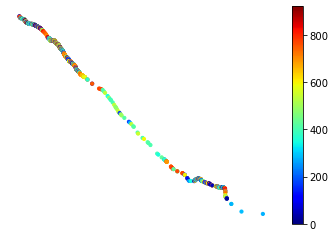

In [103]:
#i5 only
north_i5 = df[(df["route"]==5) & (df["hour"]==8) & (df["direction_of_travel"]=="N")].groupby(by="station").agg({'avg_speed': 'mean','total_flow': 'mean', "Longitude":"first", "Latitude":"first"}).sort_values(by="Latitude")
i5n_g = nx.DiGraph()
last_node = None
for i in range(len(north_i5)):
    row = north_i5.iloc[i]
    i5n_g.add_node(row.name, avg_speed=row["avg_speed"], total_flow=row["total_flow"], pos = (row['Latitude'], row['Longitude']))
    if last_node != None:
        i5n_g.add_edge(last_node, row.name)
    last_node = row.name
    
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(i5n_g,'total_flow').values())
mapping = dict(zip(sorted(groups),count()))
nodes = i5n_g.nodes()
colors = [mapping[i5n_g.nodes[n]['total_flow']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.get_node_attributes(i5n_g,'pos')
# ec = nx.draw_networkx_edges(i5n_g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(i5n_g, pos, nodelist=nodes, node_color=colors, 
                            node_size=10, cmap=plt.cm.jet)
# plt.figure(1,figsize=(20,20)) 
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [ ]:
coord_distances_df.to_csv("wcctci_coord_distances.csv")

# Get closest station to nodes for scoring

In [142]:
df_i5_avg_scores = pd.read_csv("pems_demand/station_scores_i5_only.csv")
coords = df_i5_avg_scores[["Latitude", "Longitude"]].to_numpy()
tree = spatial.KDTree(coords)

def agg_dst_score(x):
    lon = x["longitude"]
    lat = x["latitude"]
    src_res = tree.query([(lat,lon)], 2)
    closest = df_i5_avg_scores.iloc[src_res[1][0][0]]["dst_score"]
    next_closest = df_i5_avg_scores.iloc[src_res[1][0][1]]["dst_score"]
    return (closest+next_closest)/2

def agg_flow(x):
    lon = x["longitude"]
    lat = x["latitude"]
    src_res = tree.query([(lat,lon)], 2)
    closest = df_i5_avg_scores.iloc[src_res[1][0][0]]["total_flow"]
    next_closest = df_i5_avg_scores.iloc[src_res[1][0][1]]["total_flow"]
    return (closest+next_closest)/2

stations_df = pd.read_csv("data/wcctci_stations-updated.csv")
stations_df["dst_score"] = stations_df.apply(agg_dst_score, 1)
print(min(stations_df["dst_score"]), max(stations_df["dst_score"]))
stations_df.to_csv("data/stations_with_scores.csv")

0.4379281617132997 5.476004316285397


 # Results analysis 

In [6]:
with open('trials/wcctci_04_04_2022_12_15_28.pkl', 'rb') as inp:
    res = pickle.load(inp)